## S&P Global - AUTOMATIC BASELINE CORRECTION
### Misael M. Morales, Carlos Torres-Verdin, and Michael Pyrcz, UT-Austin; Murray Christie, Vladimir Rabinovich, S&P Global
#### 2024, Digital Reservoir Characterization Technology (DiReCT)
***

In [2]:
from auto_baseline_correction import *

***
# LOG ANALYSIS
***

In [3]:
# instantiate the LogAnalysis class
spl = SPLogAnalysis()
spl.__dict__

------------------------------  Log Analysis Tool  ------------------------------


{'return_data': False, 'verbose': True, 'save_fig': True}

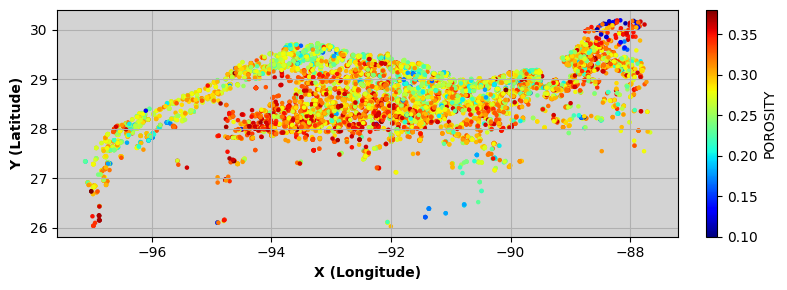

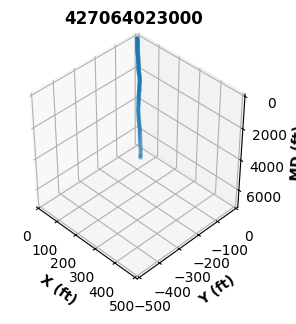

dict_keys(['DEPT', 'ASN', 'CALI', 'DRHO', 'DT', 'GR', 'GR_NORM', 'ILD', 'RHOB', 'SP', 'SP_NORM', 'VSH_GR', 'VSH_SP'])


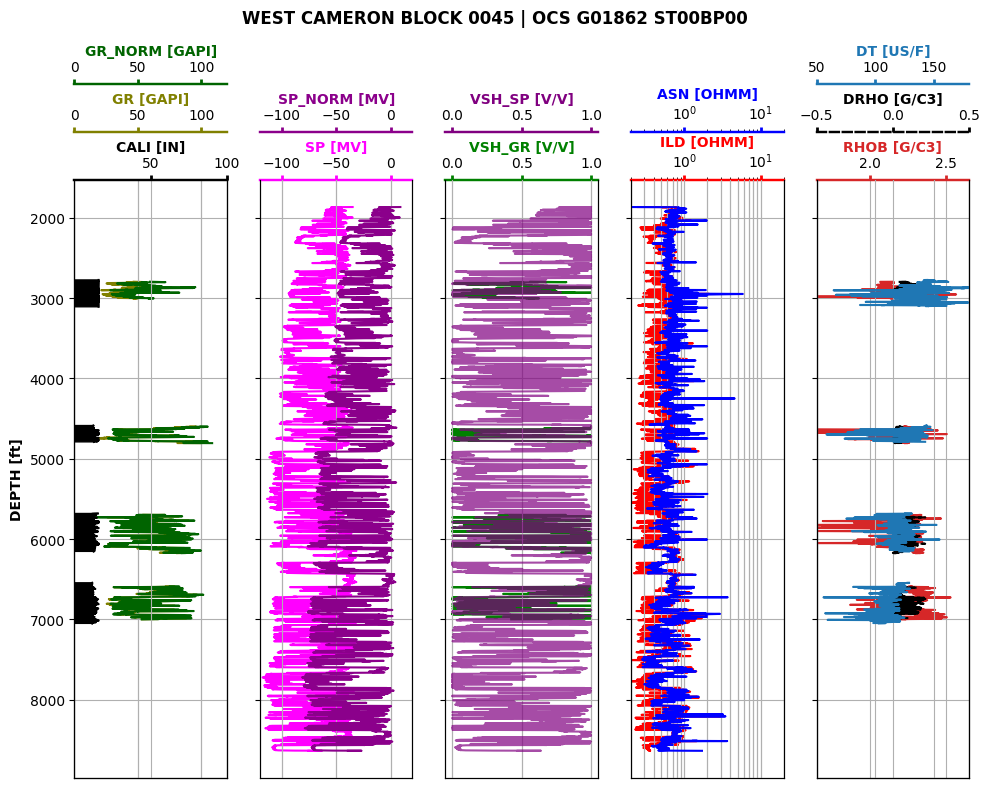

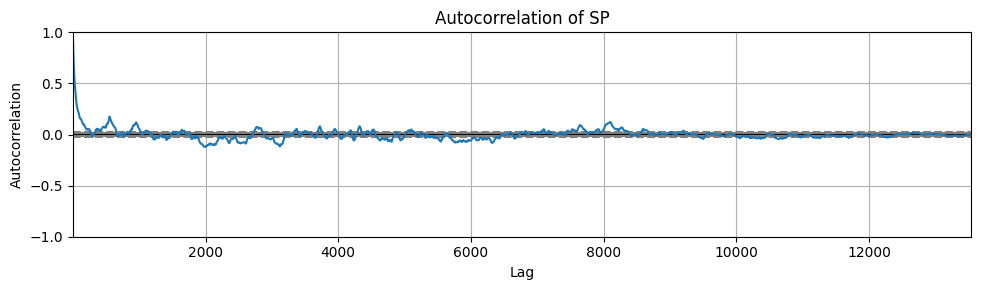

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                13543
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -28290.555
Date:                Tue, 05 Mar 2024   AIC                          56593.109
Time:                        20:31:58   BIC                          56638.190
Sample:                             0   HQIC                         56608.142
                              - 13543                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1084      0.004    314.001      0.000       1.101       1.115
ar.L2         -0.5243      0.006    -84.417      0.000      -0.536      -0.512
ar.L3          0.1098      0.008     14.372      0.0

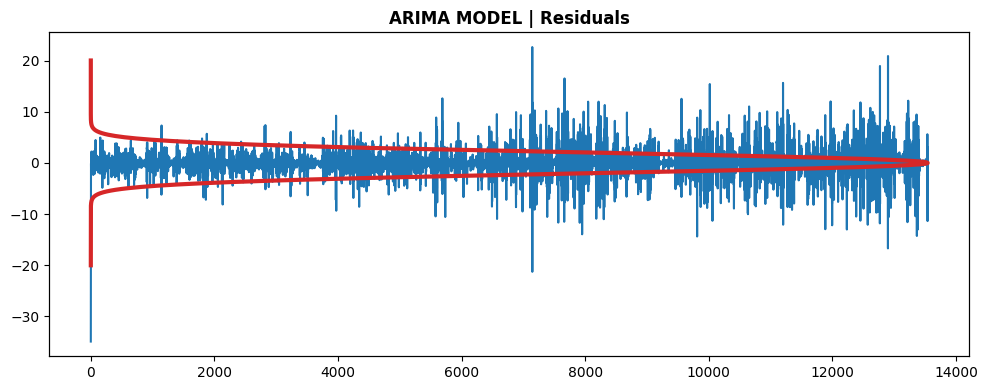

In [4]:
# ### WARNING: this takes a long time to run, only do it if you need to
# headers = spl.read_all_headers()

# Plot the spatial distribution of wells and the selected property
spl.plot_ccs_sand_wells(figsize=(8,3), value='POROSITY', cmap='jet')

# Plot a well deviation survey for a given well
spl.plot_survey(figsize=(10,3), fname='427064023000_DIRSUR_NAD27(USFEET)US-SPC27-EXACT(TX-27SC).TXT')

# Plot the full well log with multiple tracks
# also plots the autocorrelation plot and ARIMA model curve
spl.plot_well(figsize=(10,8), well_name='17700004060000', curve='SP', order=(5,1,0))

***
# SP BASELINE CORRECTION
***

In [6]:
# instanstiate the BaselineCorrection class
blc = BaselineCorrection()
blc.__dict__


 ------------------------------  Baseline Correction Tool  ------------------------------
Tensorflow built with CUDA? True
# GPU available: 1
CUDA: 12.2 | cuDNN: 8
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------


{'log_length': 44055,
 'folder': 'Data/UT Export 9-19/',
 'scaler': 'standard',
 'bounds': [10, 90],
 'decimate': False,
 'decimate_q': 10,
 'dxdz': True,
 'hilbert': True,
 'detrend': True,
 'fourier': True,
 'fourier_window': [0.001, 0.025],
 'fourier_scale': 1000.0,
 'symiir': True,
 'symiir_c0': 0.5,
 'symiir_z1': 0.1,
 'savgol': True,
 'savgol_window': 15,
 'savgol_order': 2,
 'cspline': True,
 'spline_lambda': 0.0,
 'autocorr': True,
 'autocorr_method': 'fft',
 'autocorr_mode': 'same',
 'return_data': False,
 'verbose': True,
 'save_fig': True}

Well logs raw: (389, 44055, 3)
Well logs with Depth Derivative: (389, 44055, 4)
Well logs with Autocorrelation: (389, 44055, 5)
Well logs with Detrend Filter: (389, 44055, 6)
Well logs with Fourier Transform: (389, 44055, 7)
Well logs with Hilbert Transform: (389, 44055, 8)
Well logs with Symmetric IIR Filter: (389, 44055, 9)
Well logs with Savitzky-Golay Filter: (389, 44055, 10)
Well logs with Cubic Spline: (389, 44055, 11)


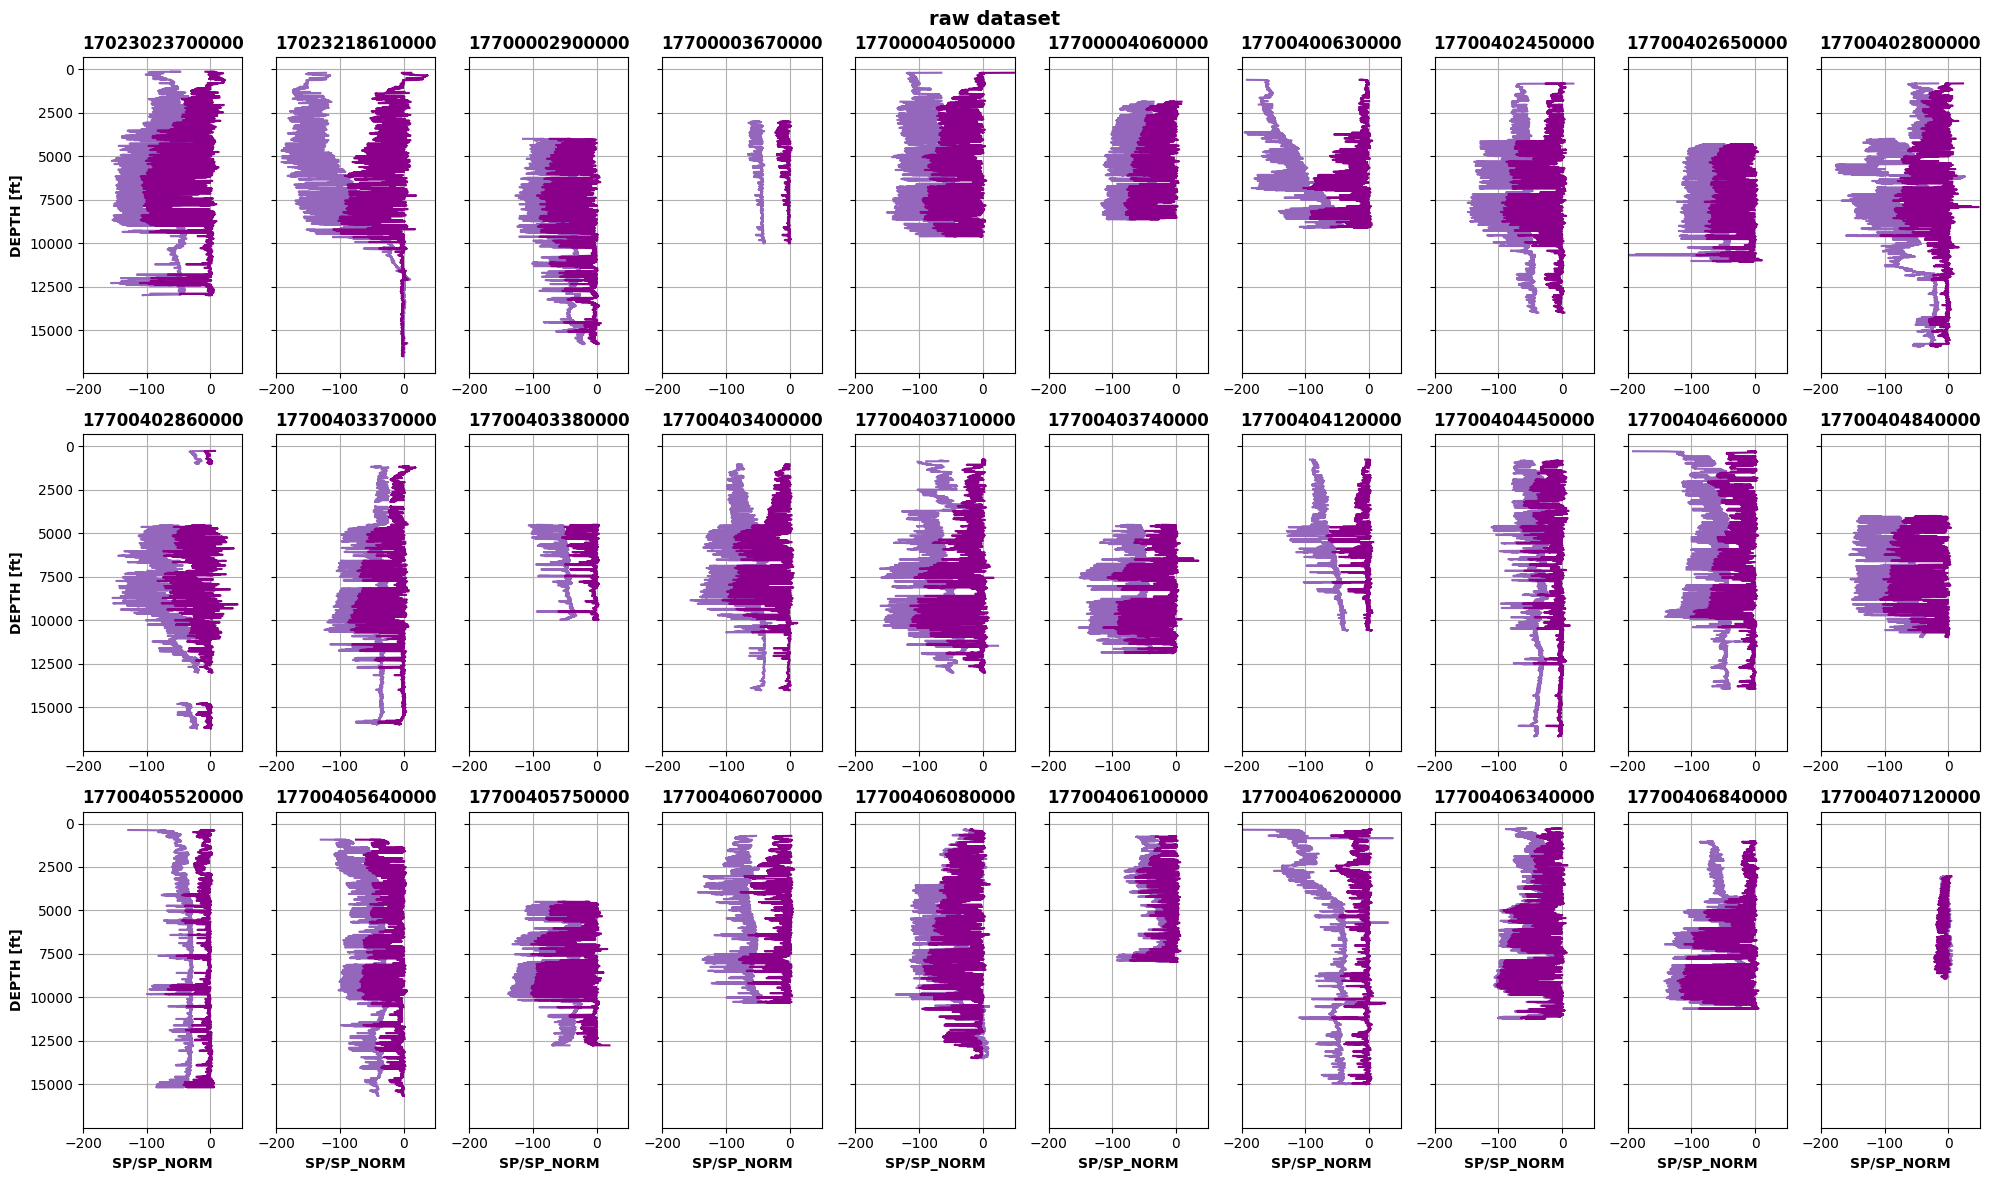

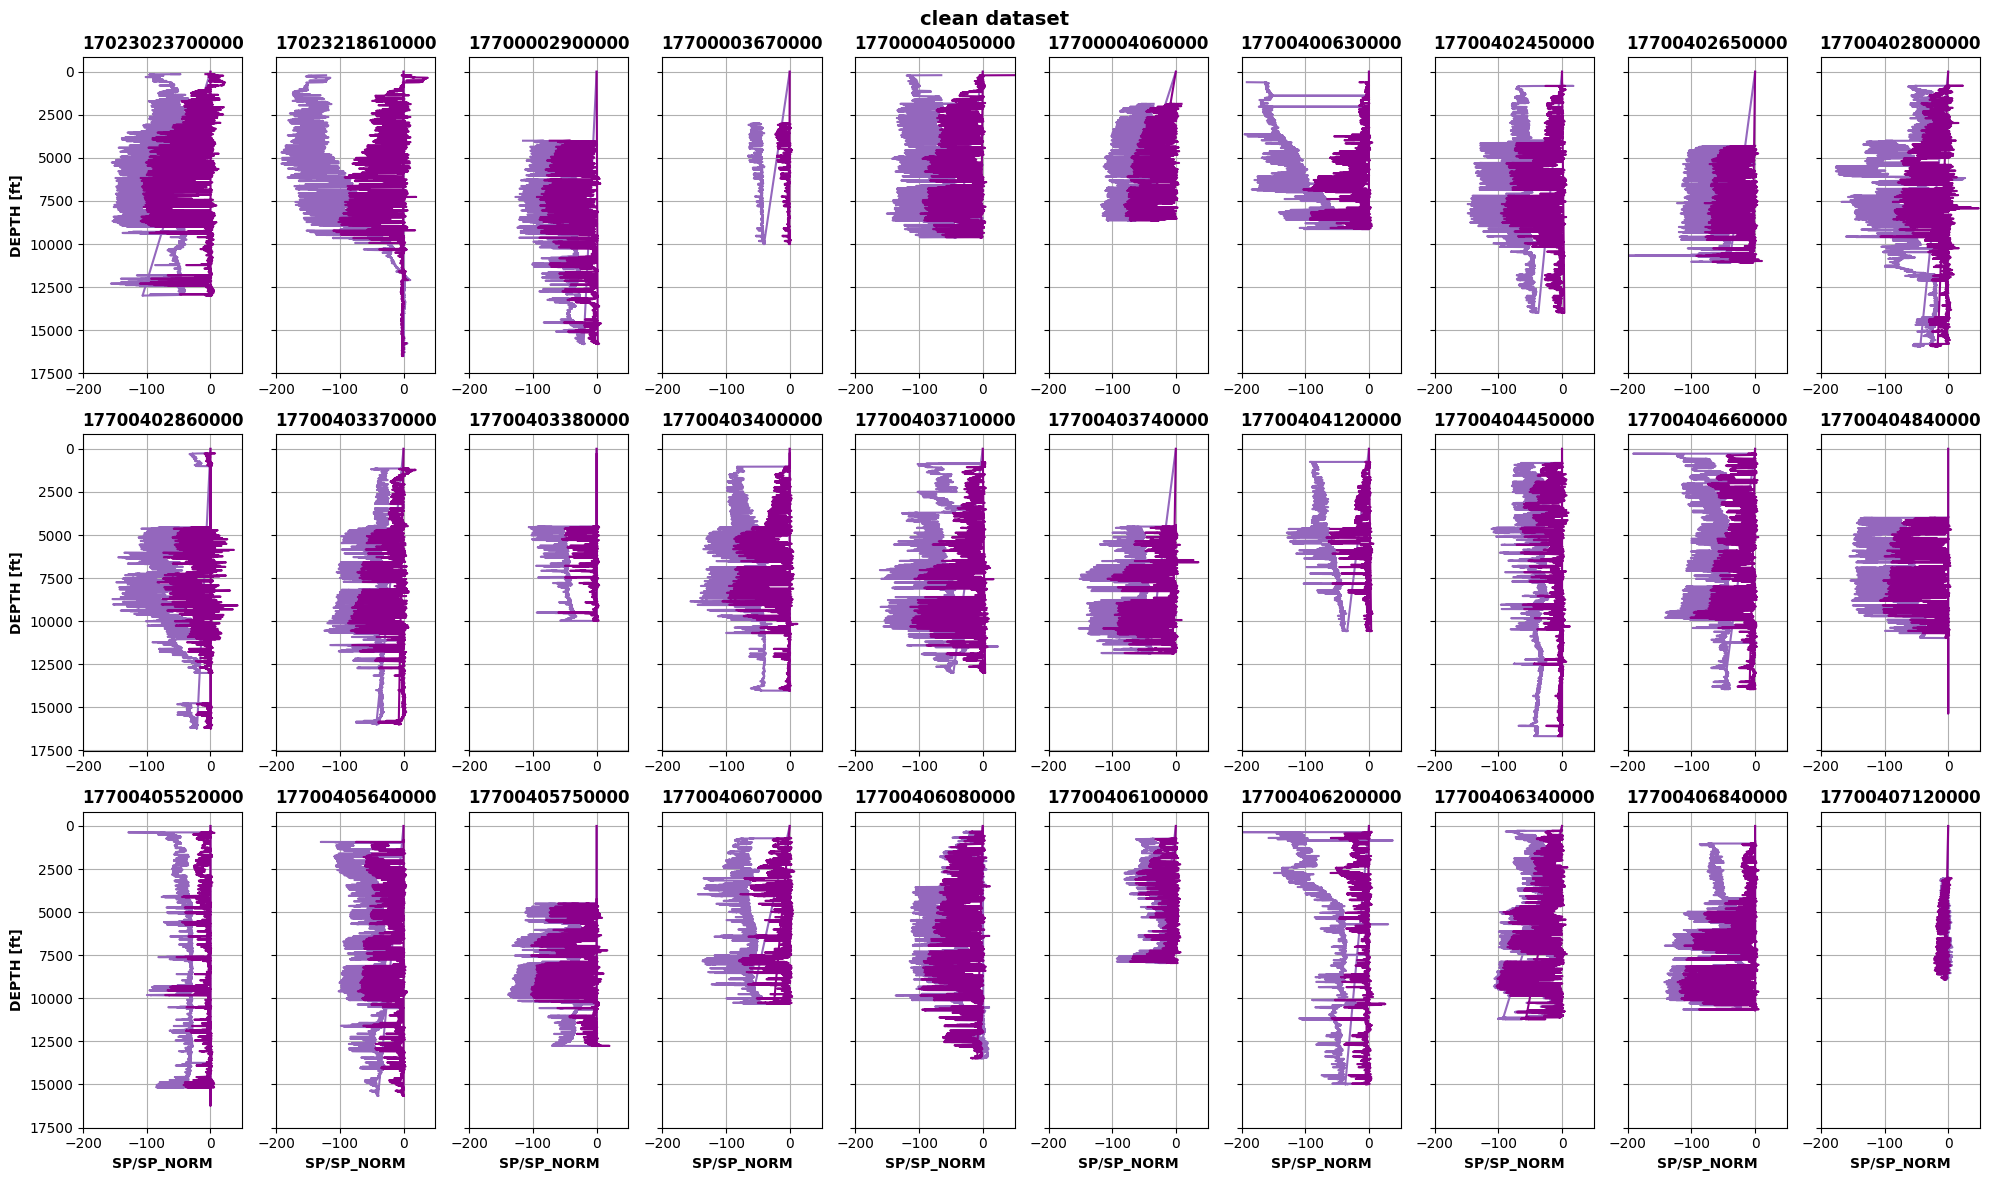

------------------------------------------------------------


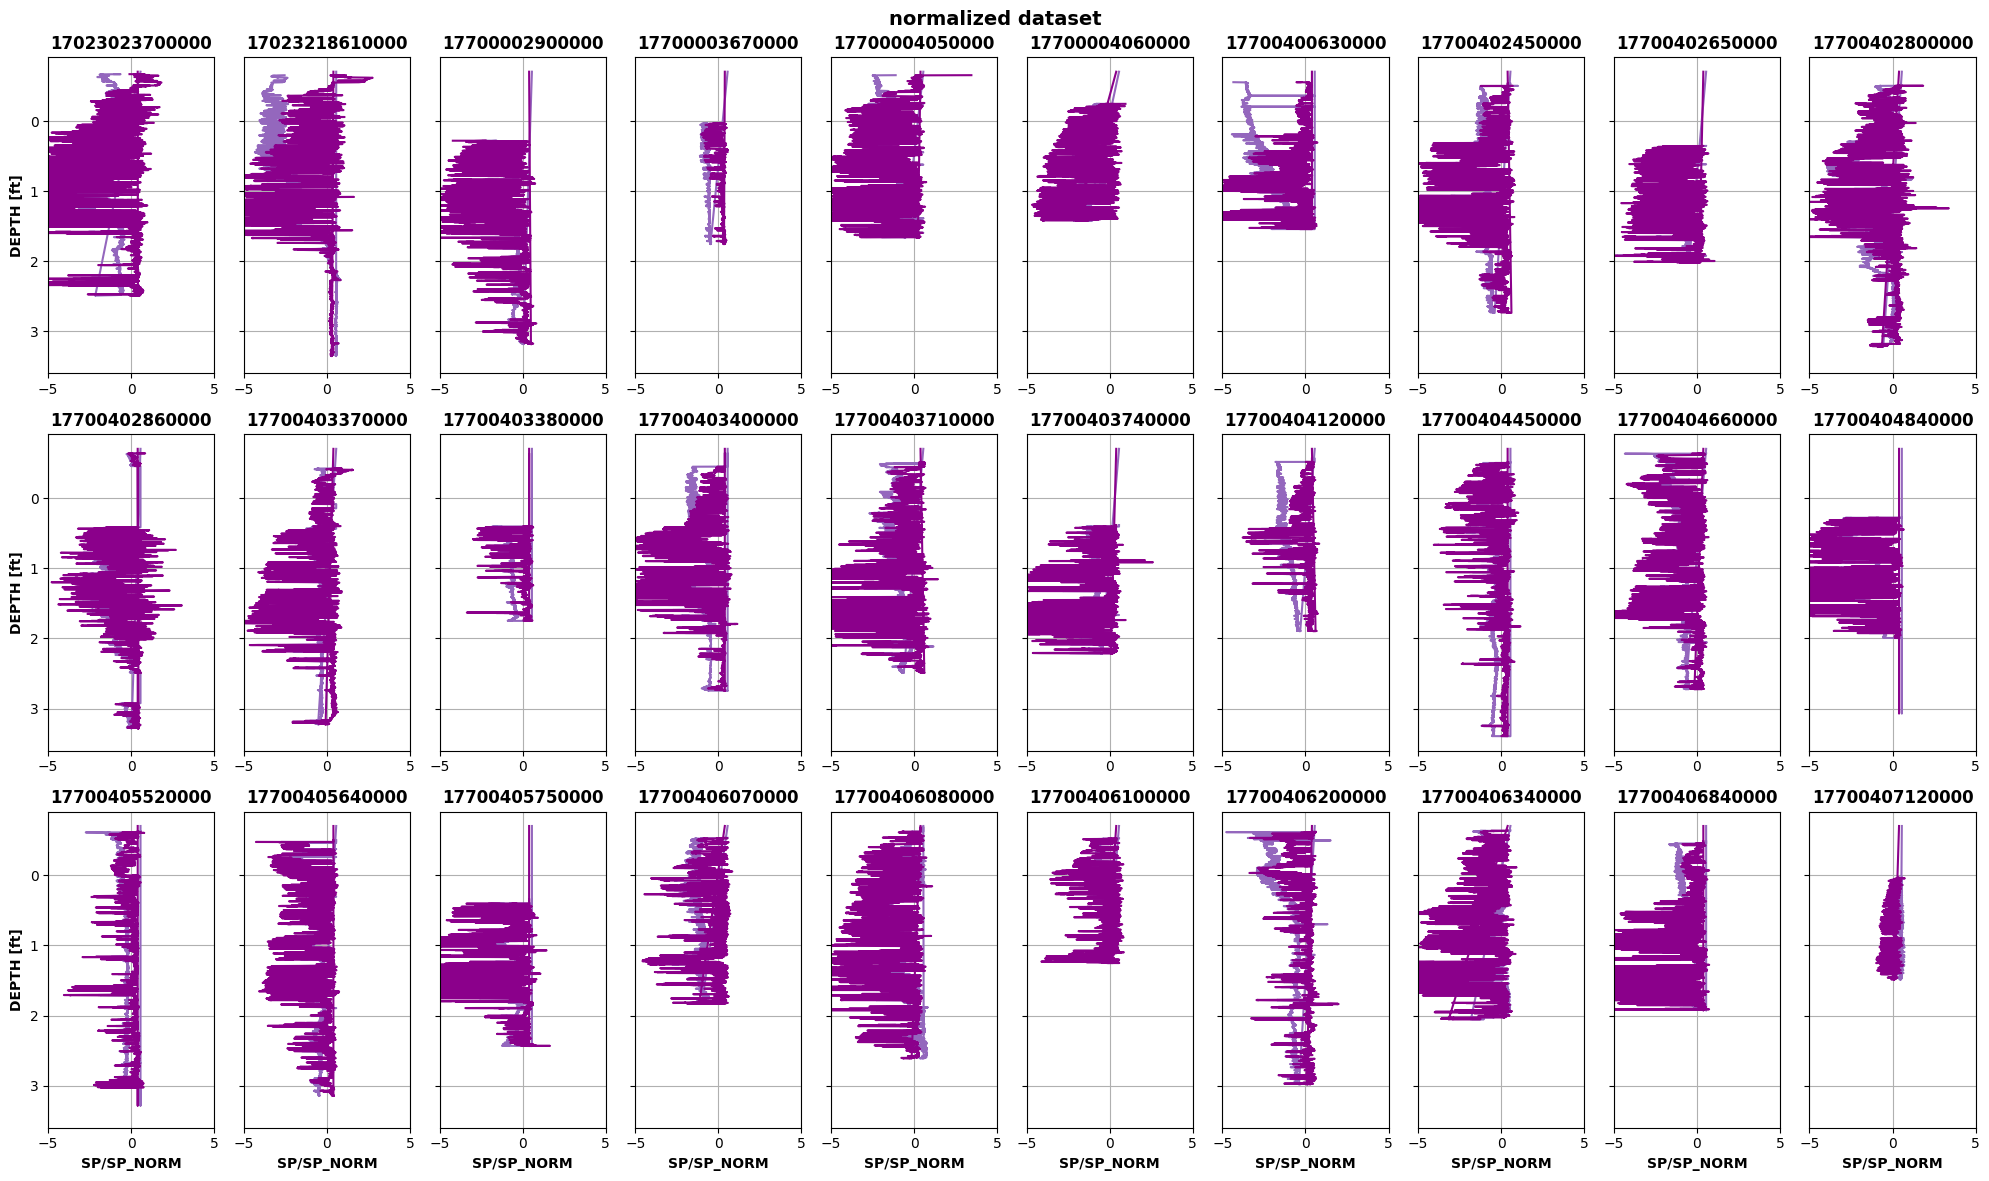

X_train: (300, 44055, 10) | X_test: (89, 44055, 10)
y_train: (300, 44055, 1) | y_test: (89, 44055, 1)


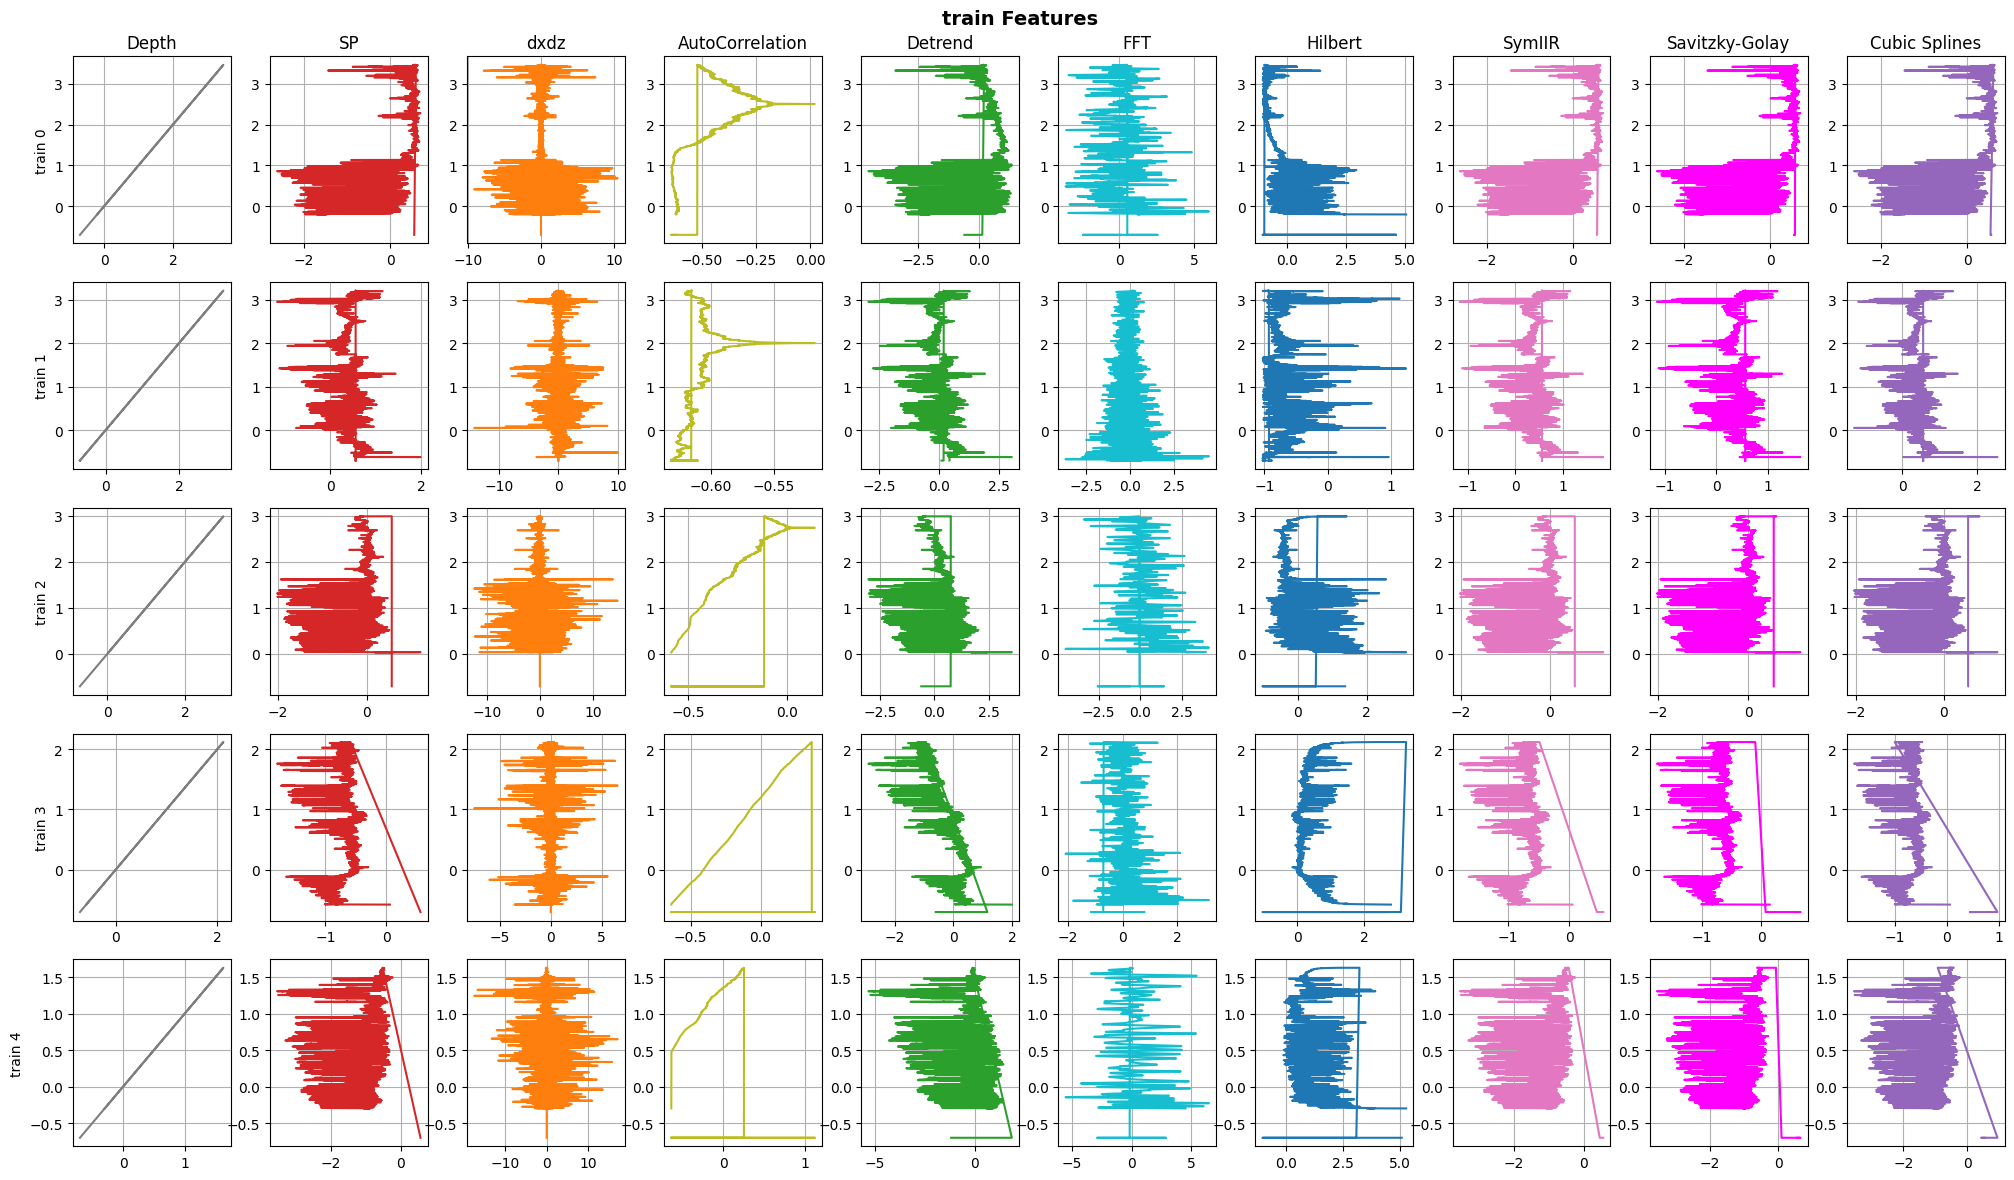

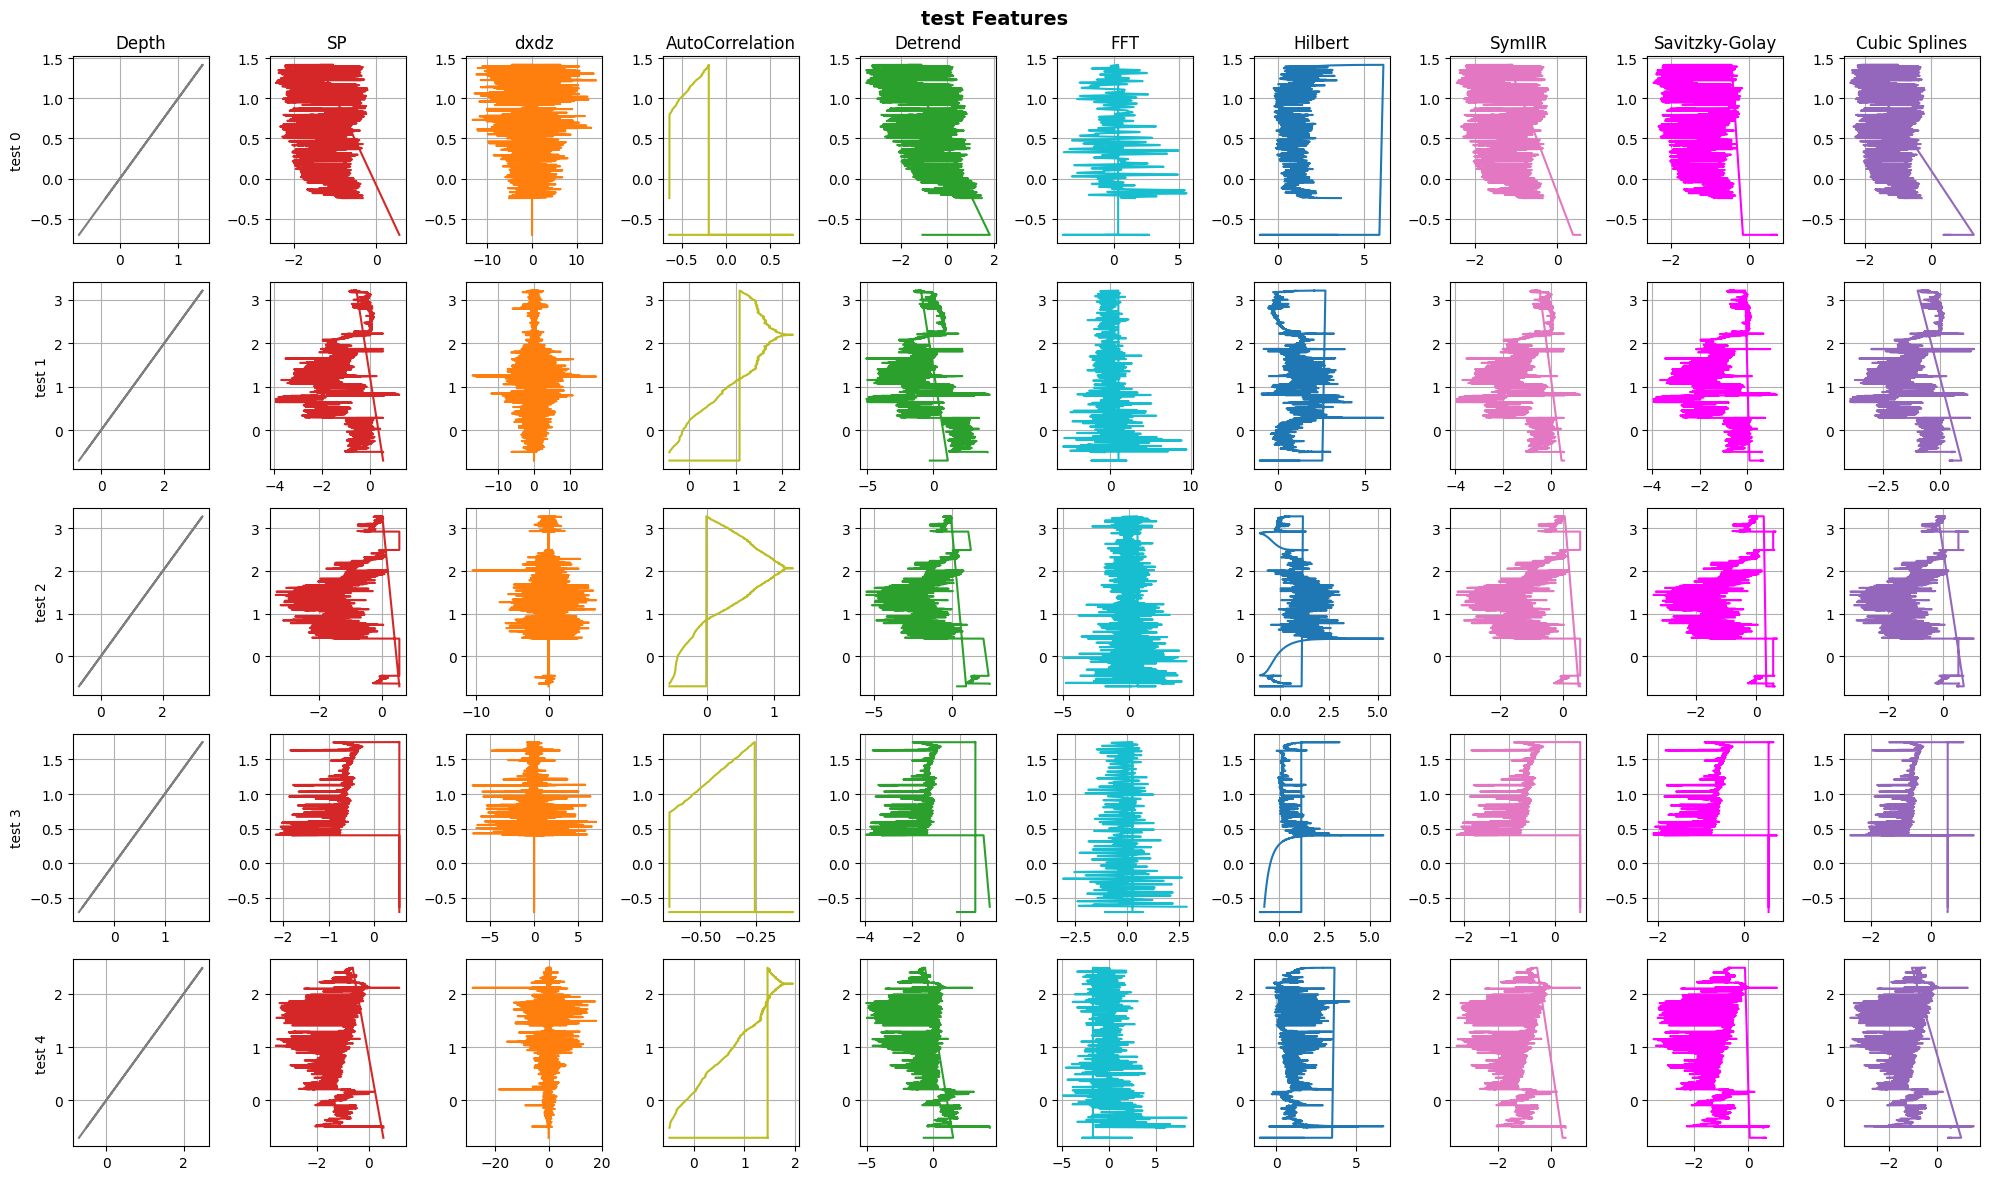

------------------------------------------------------------
-------------------------------------------------- 
 # Parameters: 89,681
------------------------------------------------------------
3/3 [==============================] - 0s 33ms/step
--------------------------------------------------
X_train: (300, 44055, 10)  | y_train: (300, 44055, 1)
X_test:  (89, 44055, 10)   | y_test:  (89, 44055, 1)
y_train_pred: (300, 44055) | y_test_pred: (89, 44055)
--------------------------------------------------
Train MSE: 0.1356 | Test MSE: 0.1314


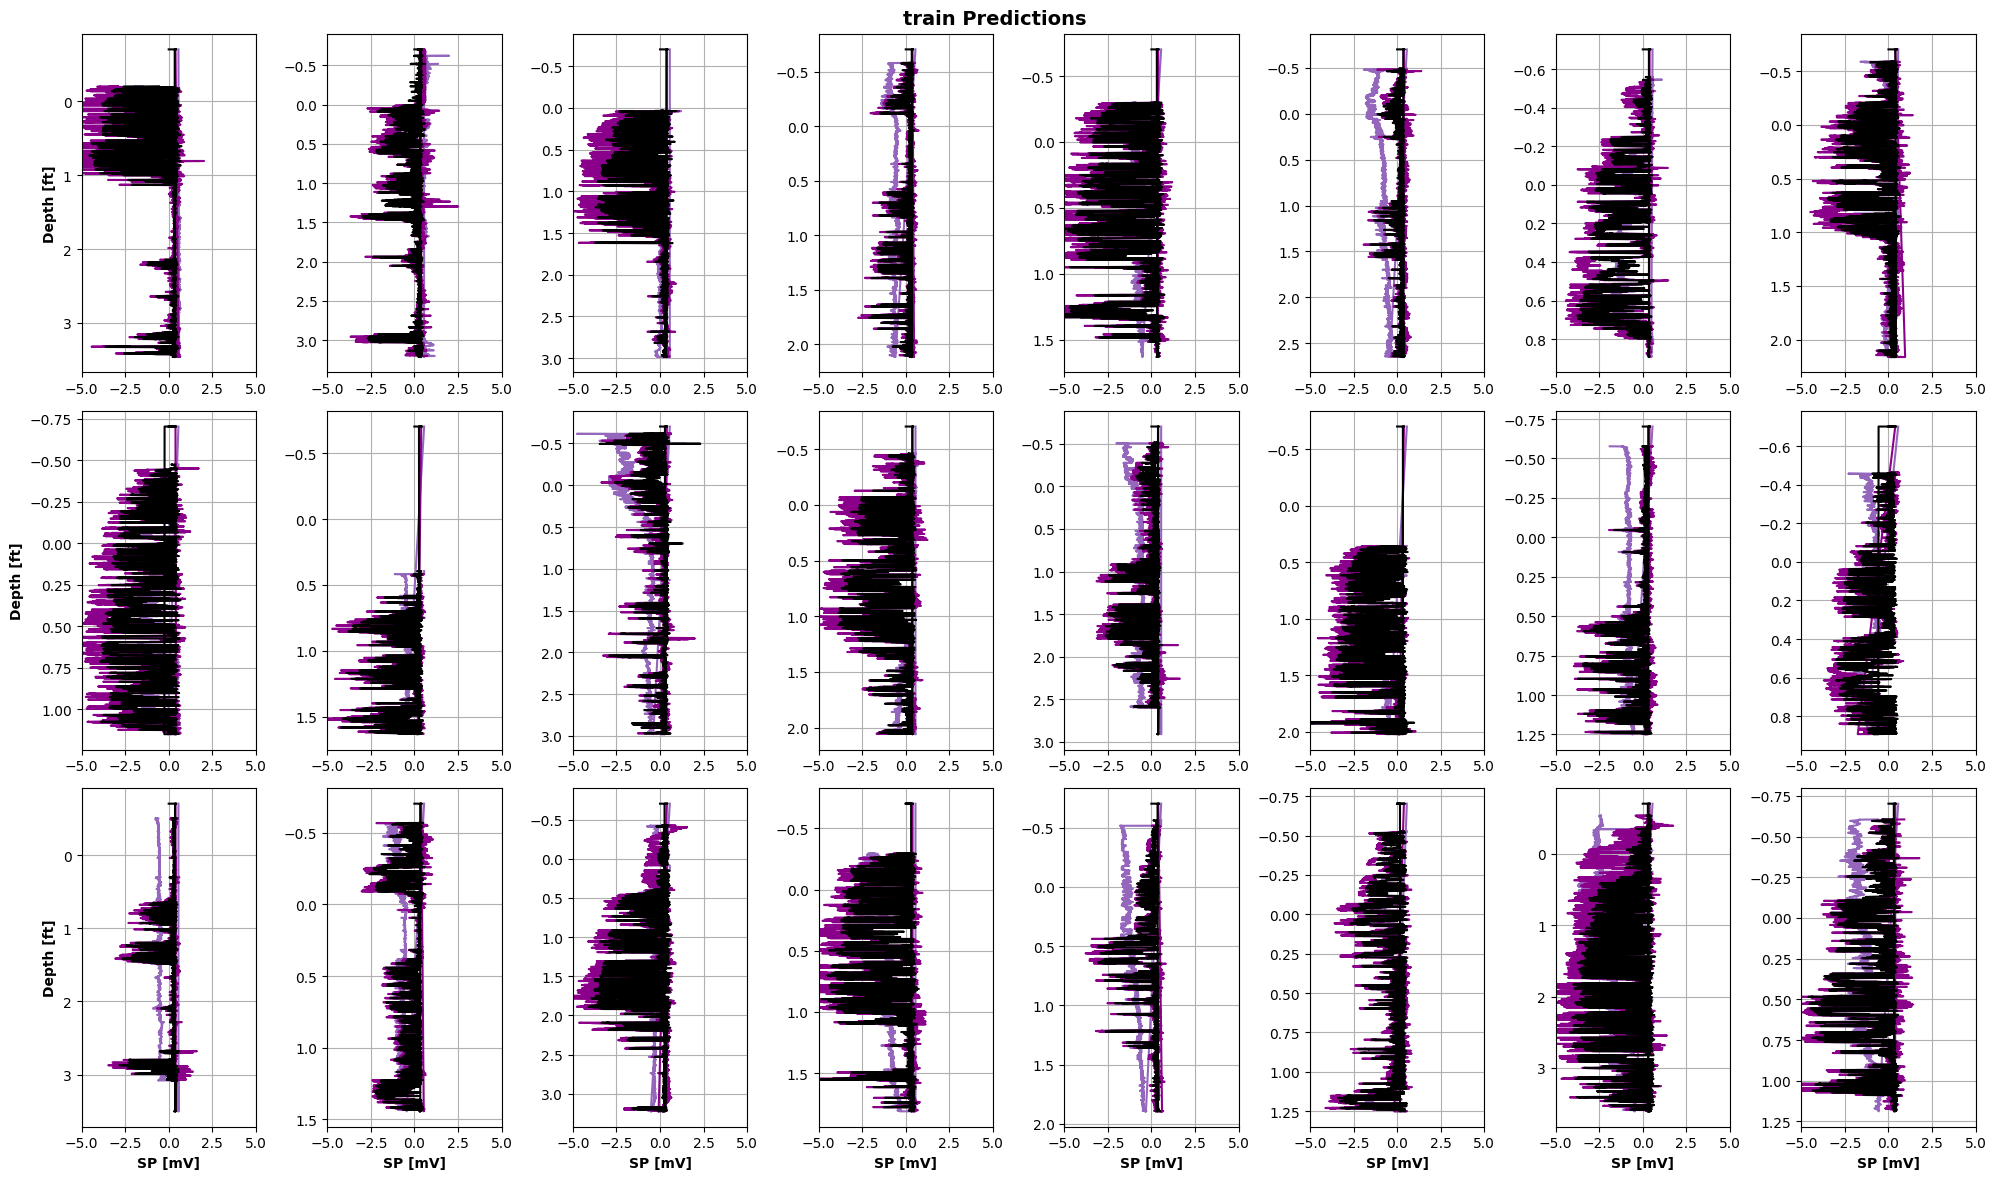

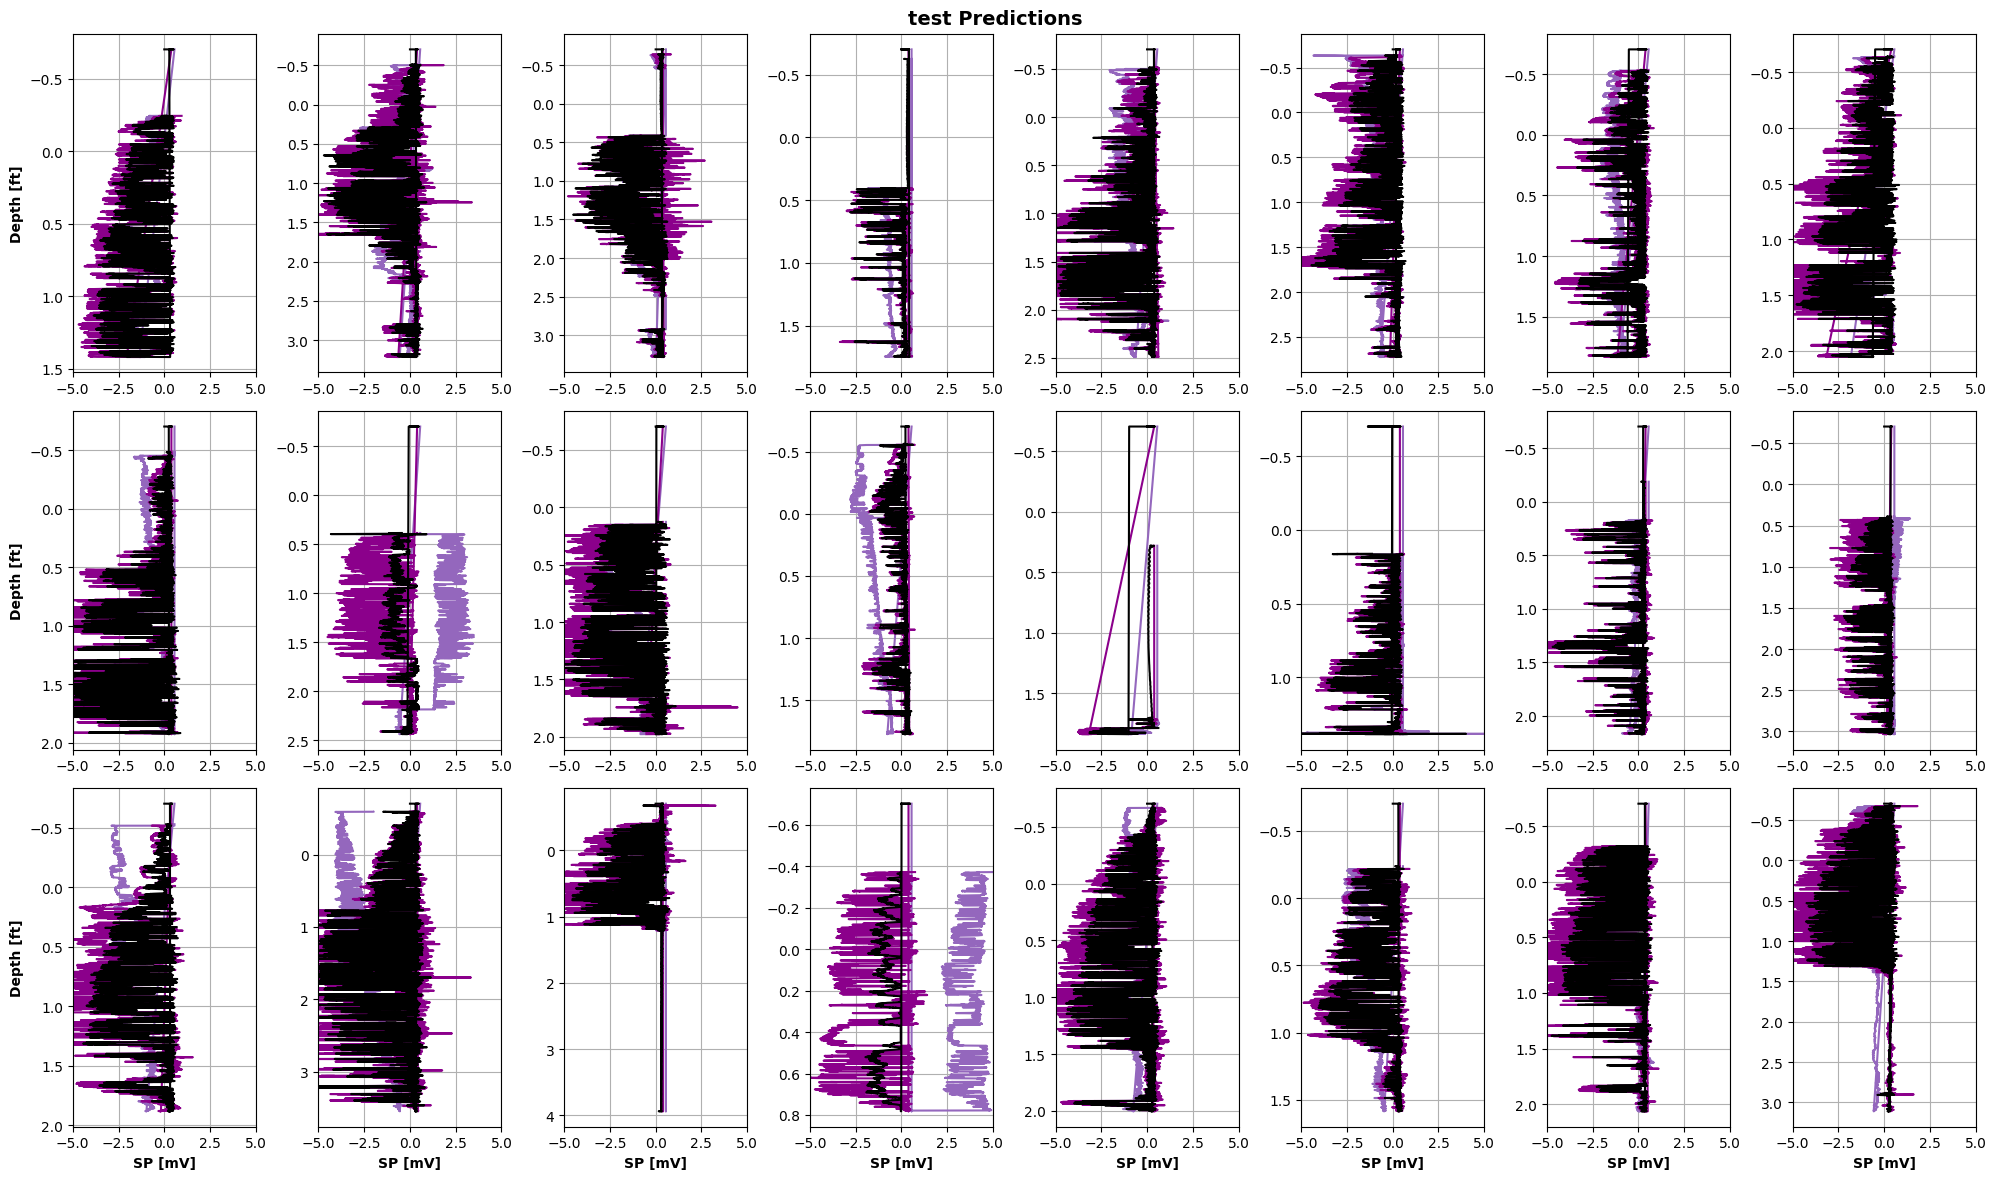

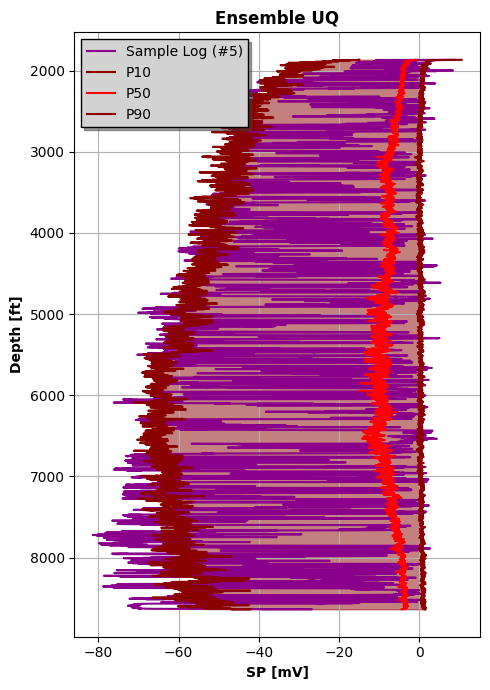

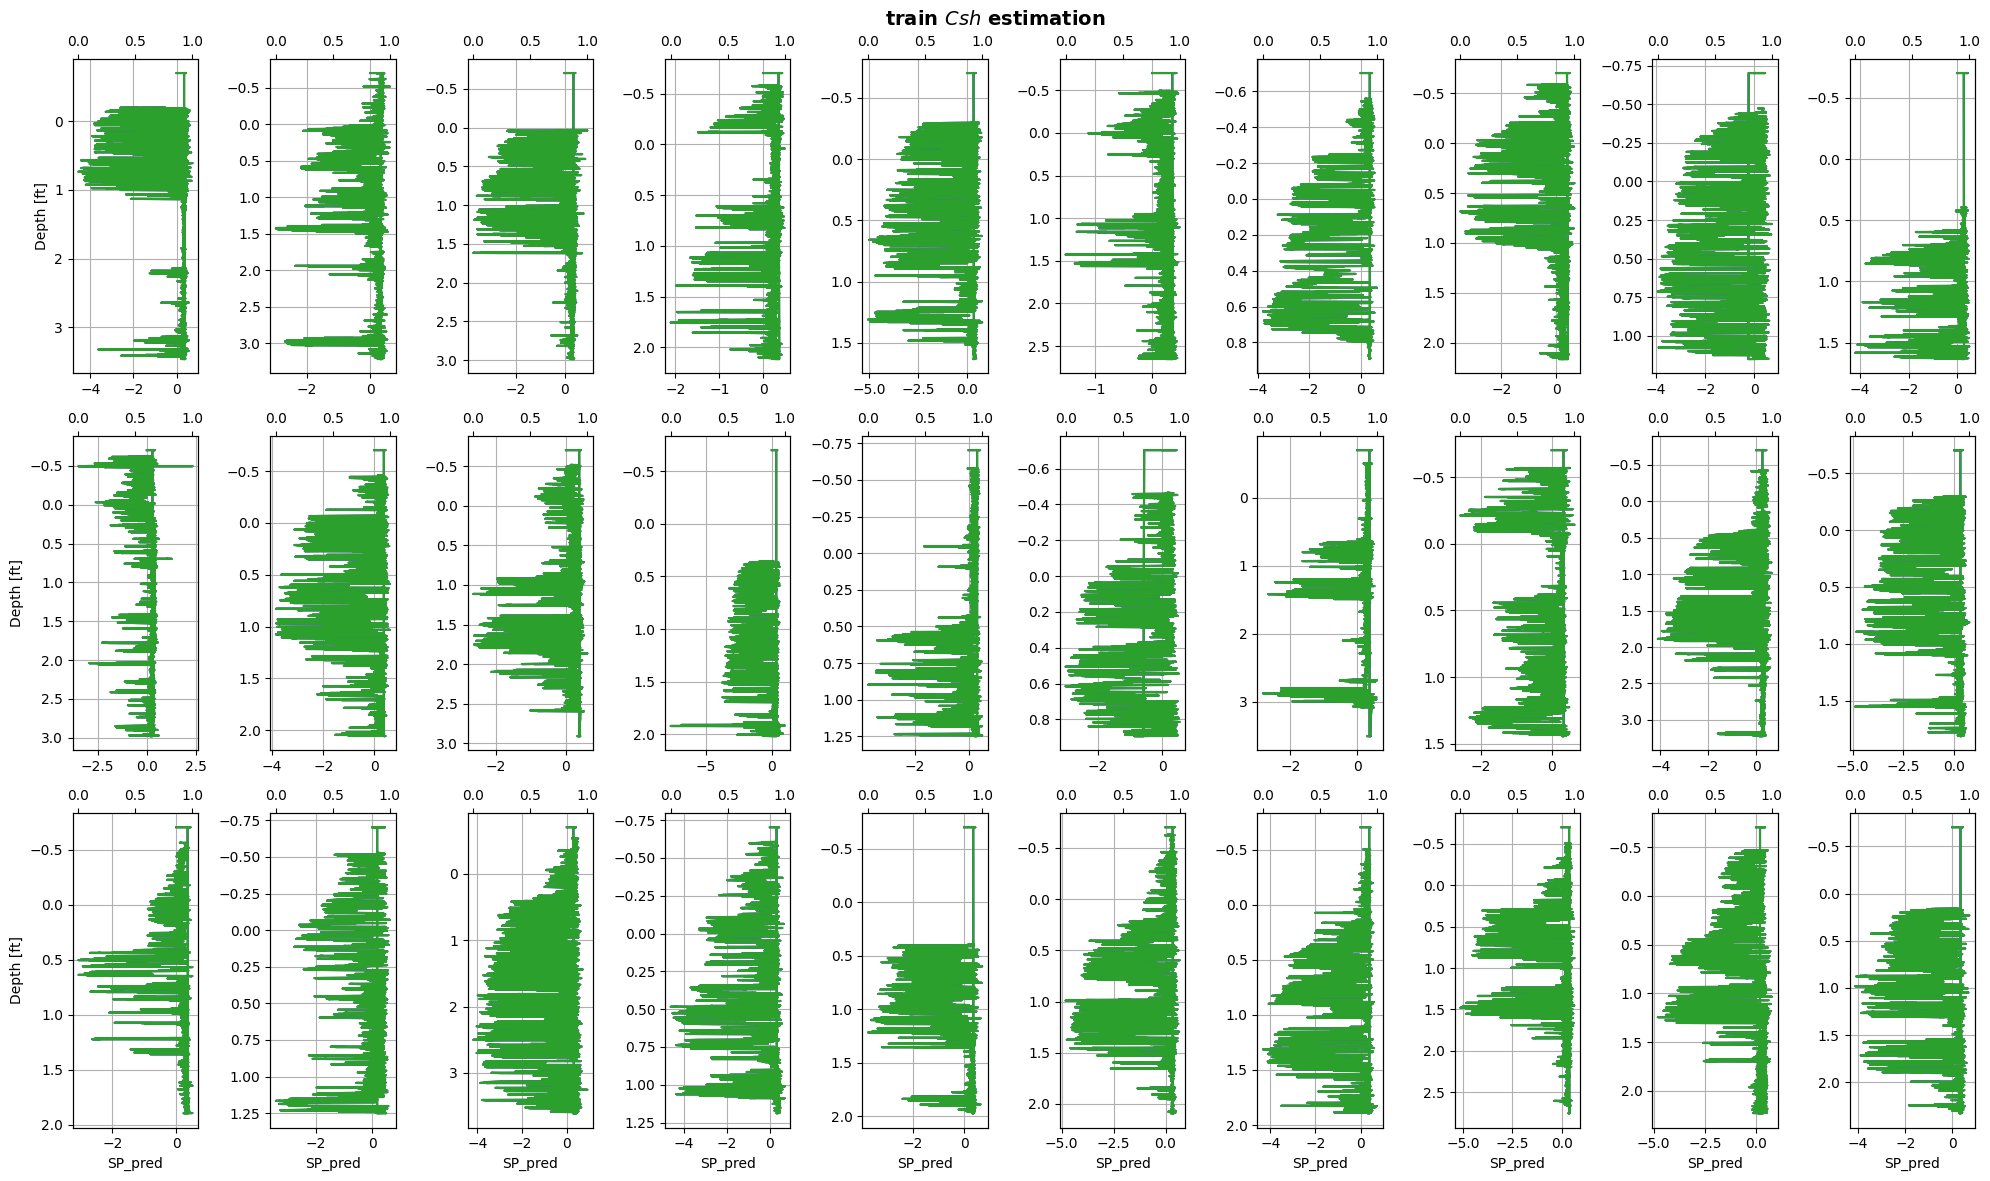

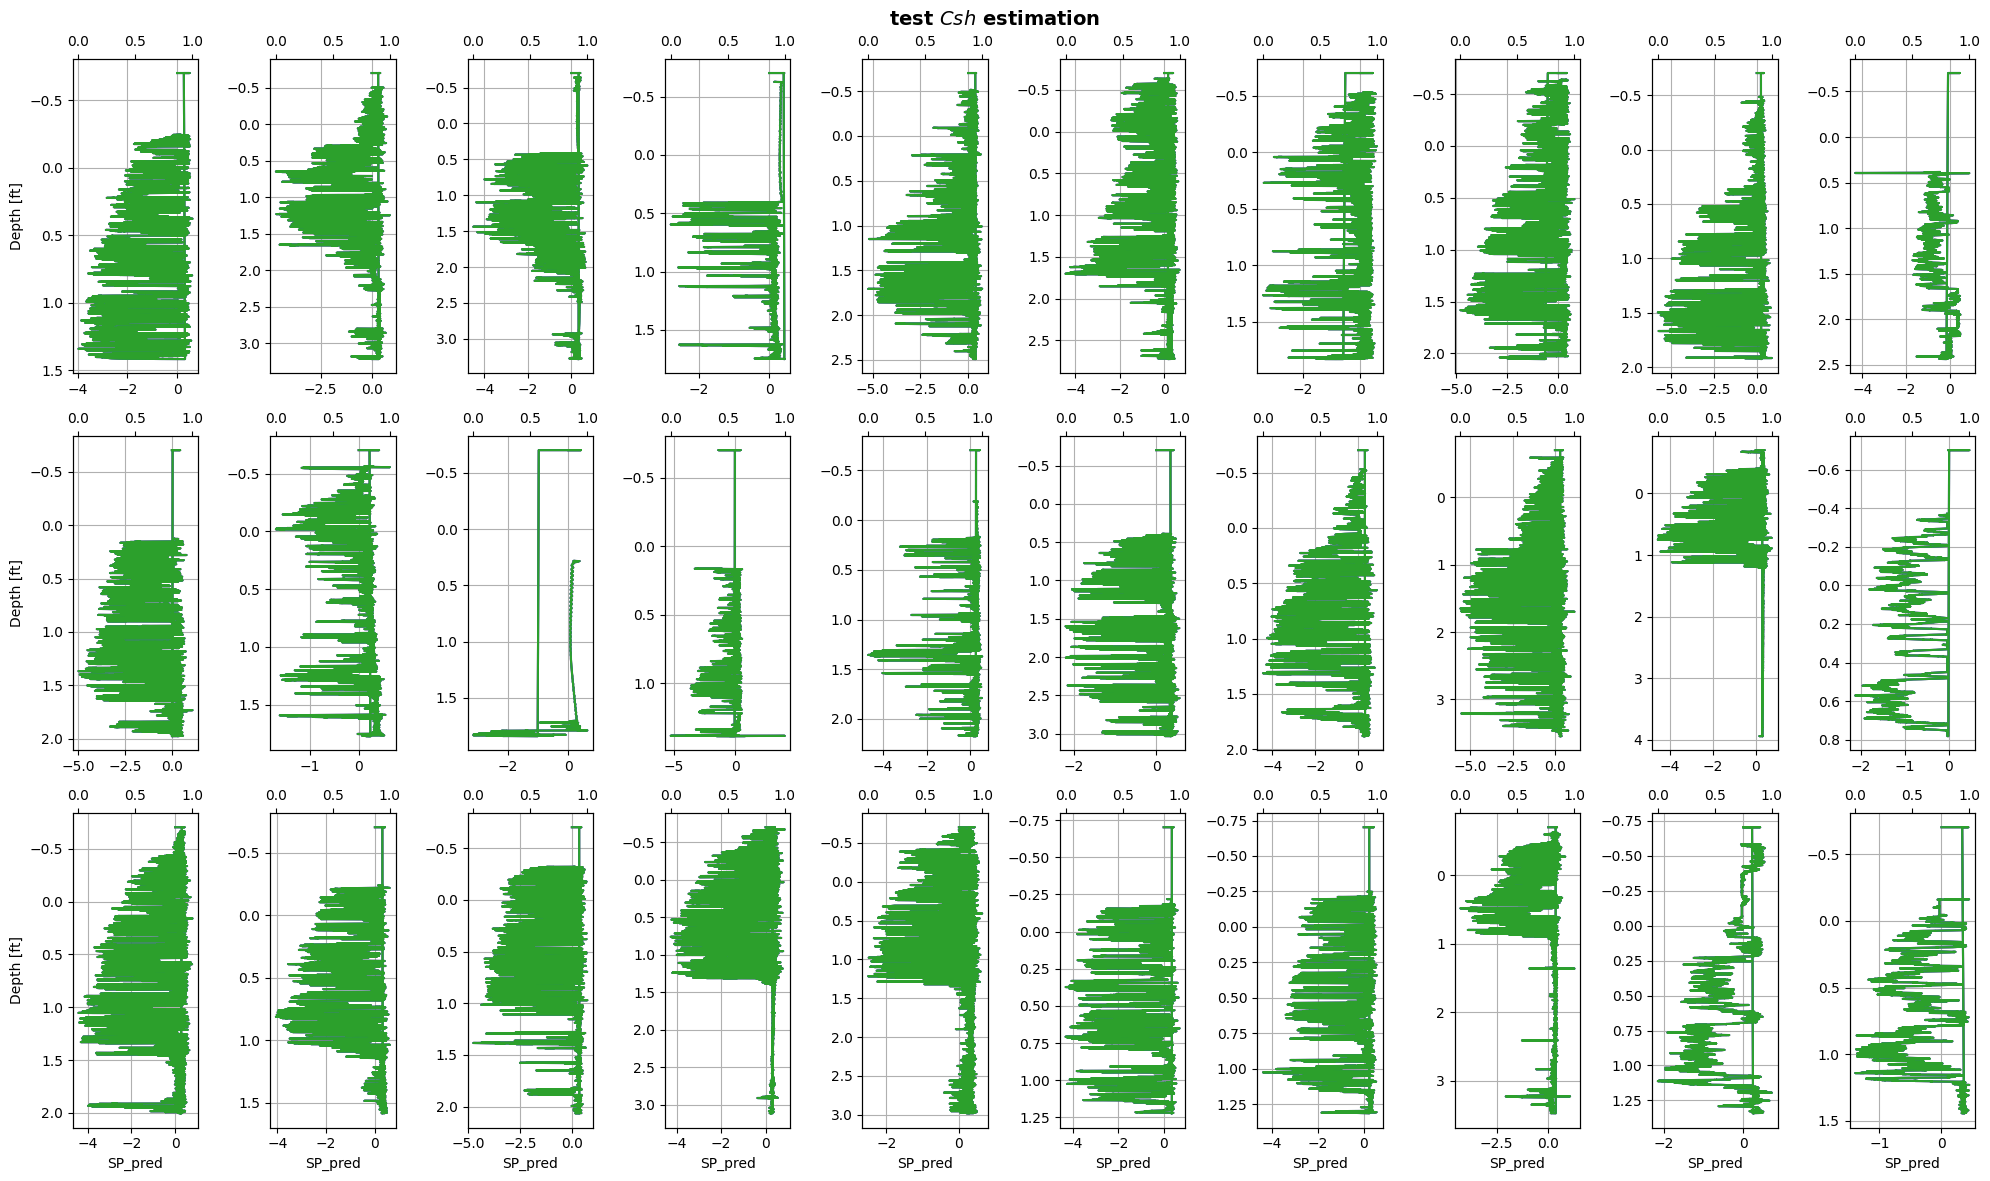

------------------------------------------------------------


In [8]:
# Load the .LAS files from scratch (preload=False). 
# This means you don't have a pre-existing .npy file with the pre-loaded data.
# The .LAS files are in your 'data' folder, and this will output a log_data.npy file with the preprocessed logs.
blc.load_logs(preload      = True,                  #change me to False if you don't have a pre-existing .npy file 
              preload_file = 'Data/log_data.npy',   #change me (if preload_file is not 'Data/log_data.npy')
              folder       = 'Data/UT Export 9-19', #change me (if preload folder is not 'Data/UT Export 9-19' and preload=False)
              save_file    = 'Data/log_data.npy',   #change me to save your preprocessed raw logs [.LAS -> .npy]
              showfig      = True,
              )

# Process the numpy logs. 
# This will scale the data according to the chosen scaler, and perform random train_test_split
# scaler can be either ('standard', 'minmax', or 'none')
blc.scale_and_random_split(scaler='standard', 
                           test_size=0.227, 
                           showfig=True,
                          )

# Make the baseline correction NN model.
# If pretrained:
#    - the model will be loaded from the file pretrained='baseline_correction_model.keras'
# Else:
#    - we construct a model from scratch based on the auxiliary functions in the class
#    - and train the model on the training data
blc.make_model(pretrained   = 'baseline_correction_model.keras', #change me to None to train from scratch
               show_summary = False, 
               kernel_size  = 15, 
               dropout      = 0.2,
               depths       = [16,32,64], 
               optimizer    = 'adam',
               lr           = 1e-3,
               loss         = 'mse',
               metrics      = ['mse'],
               epochs       = 100,
               batch_size   = 30,
               valid_split  = 0.25,
               verbose      = True,
               figsize      = (10,5),
               )

# Make predictions on the test data and visualize results
blc.make_predictions(showfig=True, xlim=(-5,5))

***
# Transfer Learning Baseline Correction
***

In [9]:
# instantiate the TransferLearning-BaselineCorrection class
tlc = TransferLearning()
tlc.__dict__


 ------------------------------  Baseline Correction Tool  ------------------------------
Tensorflow built with CUDA? True
# GPU available: 1
CUDA: 12.2 | cuDNN: 8
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU') 
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
------------------------------------------------------------


{'log_length': 44055,
 'folder': 'Data/UT Export 9-19/',
 'scaler': 'standard',
 'bounds': [10, 90],
 'decimate': False,
 'decimate_q': 10,
 'dxdz': True,
 'hilbert': True,
 'detrend': True,
 'fourier': True,
 'fourier_window': [0.001, 0.025],
 'fourier_scale': 1000.0,
 'symiir': True,
 'symiir_c0': 0.5,
 'symiir_z1': 0.1,
 'savgol': True,
 'savgol_window': 15,
 'savgol_order': 2,
 'cspline': True,
 'spline_lambda': 0.0,
 'autocorr': True,
 'autocorr_method': 'fft',
 'autocorr_mode': 'same',
 'return_data': False,
 'verbose': True,
 'save_fig': True,
 'in_folder': 'Data/UT Export 9-19',
 'out_folder': 'Data/UT Export postprocess',
 'model': <keras.src.engine.functional.Functional at 0x7f907d8f76d0>}

In [10]:
# Run SP* and Csh estimation
# Using the pre-trained model from the BaselineCorrection class, we can predict the baseline-correct SP log
# and the Csh for every well log in the data folder. The .LAS files are updated with the 2 new curves, and 
# saved in a 'postprocess' folder.
# # warning: very slow, only run if you need to
# tlc.make_transfer_prediction()

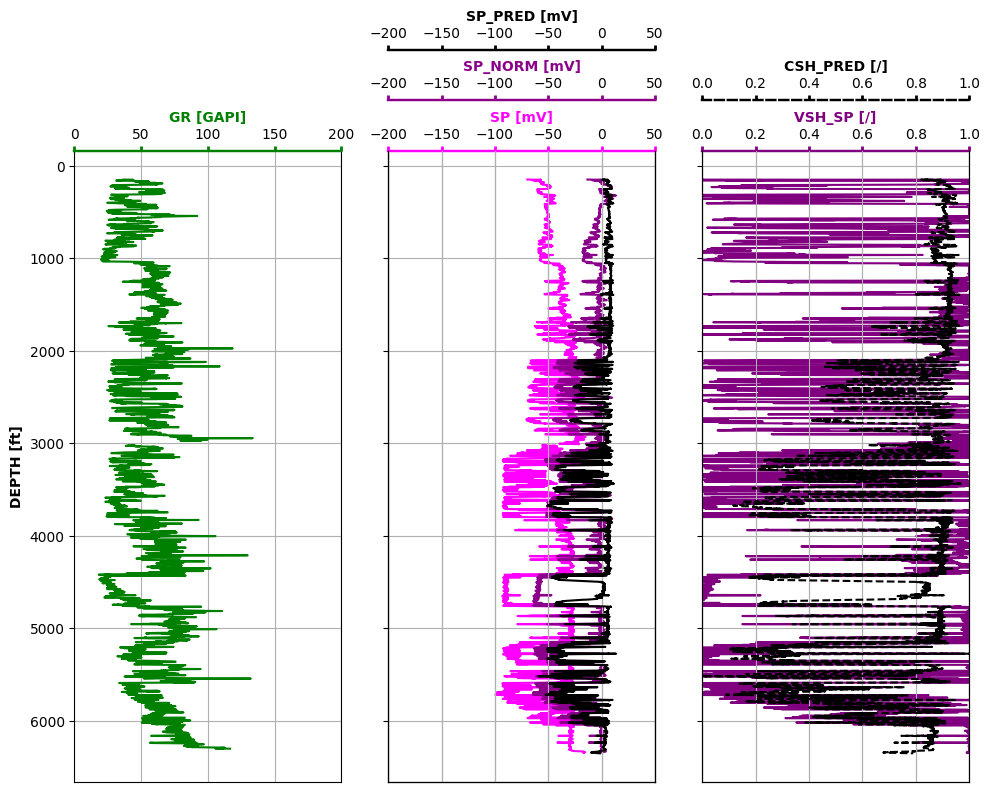

In [11]:
# Plot results of the SP baseline correction and Csh estimation for a given well
tlc.plot_transfer_results(filenum   = 69,
                          figsize   = (10,8),
                          showfig   = True,
                          add_title = False,
                        )

***
# END